In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.panel import PanelOLS, RandomEffects
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan, linear_reset
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set_style("whitegrid")

In [156]:
df = pd.read_csv('../data/processed/02_eda_cleaned_eu_analysis_data.csv')

In [157]:
df = df.set_index(['geo', 'time'])

In [158]:
X = df.drop(["house_price_index"], axis=1)
y = df["house_price_index"]

In [159]:
fe_model = PanelOLS(y, X, entity_effects=True)
fe_res = fe_model.fit()

re_model = RandomEffects(y, X)
re_res = re_model.fit()

def hausman_test(fe_results, re_results, reg=1e-8):
    # Extragem coeficienții și eliminăm constantul, dacă există
    b_fe = fe_results.params.copy()
    b_re = re_results.params.copy()

    for name in ['const', 'Intercept']:
        if name in b_fe.index:
            b_fe = b_fe.drop(name)
        if name in b_re.index:
            b_re = b_re.drop(name)

    # Aliniem coeficienții comuni între modele
    common_index = b_fe.index.intersection(b_re.index)
    b_fe = b_fe[common_index]
    b_re = b_re[common_index]

    # Calculăm diferența coeficienților
    b_diff = b_fe - b_re

    # Extragem matricile de covarianță pentru coeficienții comuni
    cov_fe = fe_results.cov.loc[common_index, common_index]
    cov_re = re_results.cov.loc[common_index, common_index]

    # Diferența matricilor de covarianță
    cov_diff = cov_fe - cov_re

    # Adăugăm regularizare pe diagonală
    cov_diff_reg = cov_diff + reg * np.eye(len(common_index))

    # Calculăm statistica Hausman folosind pseudoinversa
    stat = np.dot(b_diff.T, np.linalg.pinv(cov_diff_reg)).dot(b_diff)

    # Gradele de libertate: numărul de coeficienți comparați
    df_diff = len(common_index)

    # Calculăm p-value pe baza distribuției chi-pătrat
    p_value = stats.chi2.sf(stat, df_diff)
    return stat, p_value

hausman_stat, hausman_p = hausman_test(fe_res, re_res)
print(f"Hausman test statistic: {hausman_stat:.4f}")
print(f"p-value: {hausman_p:.4f}")

Hausman test statistic: 66.7578
p-value: 0.0000


In [160]:
fe_model = PanelOLS(y, X, entity_effects=True)

fe_res = fe_model.fit()

print(fe_res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:      house_price_index   R-squared:                        0.5587
Estimator:                   PanelOLS   R-squared (Between):             -2.5699
No. Observations:                 364   R-squared (Within):               0.5587
Date:                Mon, Mar 03 2025   R-squared (Overall):             -0.7186
Time:                        18:29:44   Log-likelihood                   -985.35
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      70.049
Entities:                          26   P-value                           0.0000
Avg Obs:                       14.000   Distribution:                   F(6,332)
Min Obs:                       14.000                                           
Max Obs:                       14.000   F-statistic (robust):             70.049
                            

In [161]:

X["log_gdp_per_capita"] = np.log1p(X["gdp_per_capita"])
X["log_pop_density"] = np.log1p(X["pop_density"])

# Pentru pop_change, aplicăm transformarea logaritmică semn-abs
def signed_log_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))

X["log_pop_change"] = X["pop_change"].apply(signed_log_transform)

X.drop(["gdp_per_capita", "pop_density", "pop_change"], axis=1, inplace=True)

In [162]:
fe_model = PanelOLS(y, X, entity_effects=True)

fe_res = fe_model.fit()

print(fe_res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:      house_price_index   R-squared:                        0.5674
Estimator:                   PanelOLS   R-squared (Between):             -309.40
No. Observations:                 364   R-squared (Within):               0.5674
Date:                Mon, Mar 03 2025   R-squared (Overall):             -125.98
Time:                        18:29:45   Log-likelihood                   -981.71
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      72.583
Entities:                          26   P-value                           0.0000
Avg Obs:                       14.000   Distribution:                   F(6,332)
Min Obs:                       14.000                                           
Max Obs:                       14.000   F-statistic (robust):             72.583
                            

In [163]:
X.drop(["log_pop_change", "log_pop_density"], axis=1, inplace=True)

In [164]:
fe_model = PanelOLS(y, X, entity_effects=True)

fe_res = fe_model.fit()

print(fe_res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:      house_price_index   R-squared:                        0.5643
Estimator:                   PanelOLS   R-squared (Between):             -77.425
No. Observations:                 364   R-squared (Within):               0.5643
Date:                Mon, Mar 03 2025   R-squared (Overall):             -31.276
Time:                        18:29:45   Log-likelihood                   -983.00
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      108.17
Entities:                          26   P-value                           0.0000
Avg Obs:                       14.000   Distribution:                   F(4,334)
Min Obs:                       14.000                                           
Max Obs:                       14.000   F-statistic (robust):             108.17
                            

In [171]:
# 1. Modelul pooled OLS pentru testul RESET
pooled_exog = sm.add_constant(X)
pooled_model = sm.OLS(y, pooled_exog).fit()
reset_test = linear_reset(pooled_model, power=2, use_f=True)
print("=== Ramsey RESET test ===")
print(reset_test)
print("\n")

# 2. Testul de heteroscedasticitate (Breusch-Pagan)
bp_test = het_breuschpagan(fe_res.resids, pooled_exog)
print("=== Breusch-Pagan test ===")
print("LM Statistic:", bp_test[0])
print("LM Test p-value:", bp_test[1])
print("F-Statistic:", bp_test[2])
print("F-Test p-value:", bp_test[3])
print("\n")

# 3. Testul de autocorelare (Durbin-Watson, )
dw_stat = durbin_watson(fe_res.resids)
print("=== Durbin-Watson test ===")
print("Durbin-Watson statistic:", dw_stat)
print("\n")

# 4. Testul VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = pooled_exog.columns
vif_data["VIF"] = [variance_inflation_factor(pooled_exog.values, i) for i in range(pooled_exog.shape[1])]
print("=== Variance Inflation Factors (VIF) ===")
print(vif_data)
print("\n")


# 5. Testul de normalitate al reziduurilor (Jarque-Bera)
jb_stat, jb_p, skew, kurtosis = jarque_bera(fe_res.resids)
print("=== Jarque-Bera test ===")
print("JB Statistic:", jb_stat)
print("JB p-value:", jb_p)
print("Skewness:", skew)
print("Kurtosis:", kurtosis)
print("\n")

=== Ramsey RESET test ===
<F test: F=13.592887390524087, p=0.00026222311556138583, df_denom=358, df_num=1>


=== Breusch-Pagan test ===
LM Statistic: 19.359759162860847
LM Test p-value: 0.0006678025425503758
F-Statistic: 5.0416004255517
F-Test p-value: 0.0005789237607437721


=== Durbin-Watson test ===
Durbin-Watson statistic: 1.6731174416737122


=== Variance Inflation Factors (VIF) ===
               Feature         VIF
0                const  314.736287
1     building_permits    1.034414
2  construction_prices    1.185060
3    unemployment_rate    1.349863
4   log_gdp_per_capita    1.123417


=== Jarque-Bera test ===
JB Statistic: 91.49120518670712
JB p-value: 1.3581171154265678e-20
Skewness: -0.12160985587963477
Kurtosis: 5.444019502168352




In [166]:
fe_model = fe_model.fit(cov_type='clustered', cluster_entity=True)
print(fe_model.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:      house_price_index   R-squared:                        0.5643
Estimator:                   PanelOLS   R-squared (Between):             -77.425
No. Observations:                 364   R-squared (Within):               0.5643
Date:                Mon, Mar 03 2025   R-squared (Overall):             -31.276
Time:                        18:29:45   Log-likelihood                   -983.00
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      108.17
Entities:                          26   P-value                           0.0000
Avg Obs:                       14.000   Distribution:                   F(4,334)
Min Obs:                       14.000                                           
Max Obs:                       14.000   F-statistic (robust):             73.285
                            

In [167]:
# 1. Modelul pooled OLS pentru testul RESET
pooled_exog = sm.add_constant(X)
pooled_model = sm.OLS(y, pooled_exog).fit()
reset_test = linear_reset(pooled_model, power=2, use_f=True)
print("=== Ramsey RESET test ===")
print(reset_test)
print("\n")

# 2. Testul de heteroscedasticitate (Breusch-Pagan)
bp_test = het_breuschpagan(fe_res.resids, pooled_exog)
print("=== Breusch-Pagan test ===")
print("LM Statistic:", bp_test[0])
print("LM Test p-value:", bp_test[1])
print("F-Statistic:", bp_test[2])
print("F-Test p-value:", bp_test[3])
print("\n")

# 3. Testul de autocorelare (Durbin-Watson, )
dw_stat = durbin_watson(fe_res.resids)
print("=== Durbin-Watson test ===")
print("Durbin-Watson statistic:", dw_stat)
print("\n")

# 4. Testul VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = pooled_exog.columns
vif_data["VIF"] = [variance_inflation_factor(pooled_exog.values, i) for i in range(pooled_exog.shape[1])]
print("=== Variance Inflation Factors (VIF) ===")
print(vif_data)
print("\n")


# 5. Testul de normalitate al reziduurilor (Jarque-Bera)
jb_stat, jb_p, skew, kurtosis = jarque_bera(fe_res.resids)
print("=== Jarque-Bera test ===")
print("JB Statistic:", jb_stat)
print("JB p-value:", jb_p)
print("Skewness:", skew)
print("Kurtosis:", kurtosis)
print("\n")

=== Ramsey RESET test ===
<F test: F=13.592887390524087, p=0.00026222311556138583, df_denom=358, df_num=1>


=== Breusch-Pagan test ===
LM Statistic: 19.359759162860847
LM Test p-value: 0.0006678025425503758
F-Statistic: 5.0416004255517
F-Test p-value: 0.0005789237607437721


=== Durbin-Watson test ===
Durbin-Watson statistic: 1.6731174416737122


=== Variance Inflation Factors (VIF) ===
               Feature         VIF
0                const  314.736287
1     building_permits    1.034414
2  construction_prices    1.185060
3    unemployment_rate    1.349863
4   log_gdp_per_capita    1.123417


=== Jarque-Bera test ===
JB Statistic: 91.49120518670712
JB p-value: 1.3581171154265678e-20
Skewness: -0.12160985587963477
Kurtosis: 5.444019502168352




Random Forest MSE: 12.7168


C:\Users\nicus\AppData\Local\Temp\ipykernel_36028\343210582.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=X.columns[indices], palette="viridis")


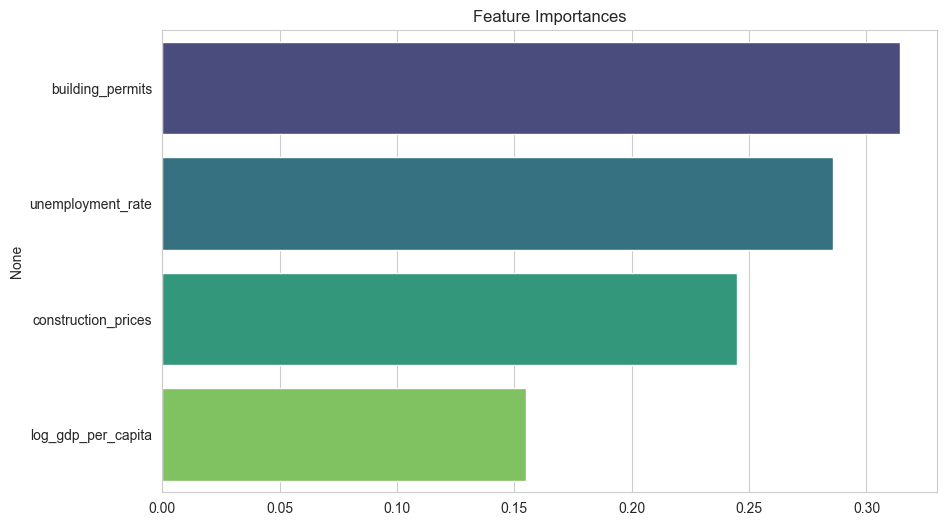

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Random Forest MSE: {mse:.4f}")

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=X.columns[indices], palette="viridis")
plt.title("Feature Importances")
plt.show()

In [169]:
from sklearn.metrics import r2_score


# Calculăm R² folosind metoda score
r2_method = rf_model.score(X_test, y_test)

# Calculăm R² folosind r2_score
r2_metric = r2_score(y_test, y_pred)

print("R² (metoda score):", r2_method)
print("R² (r2_score):", r2_metric)

R² (metoda score): 0.6182844163497676
R² (r2_score): 0.6182844163497676


XGBoost MSE: 15.6450


C:\Users\nicus\AppData\Local\Temp\ipykernel_36028\3057292292.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=X.columns[indices], palette="viridis")


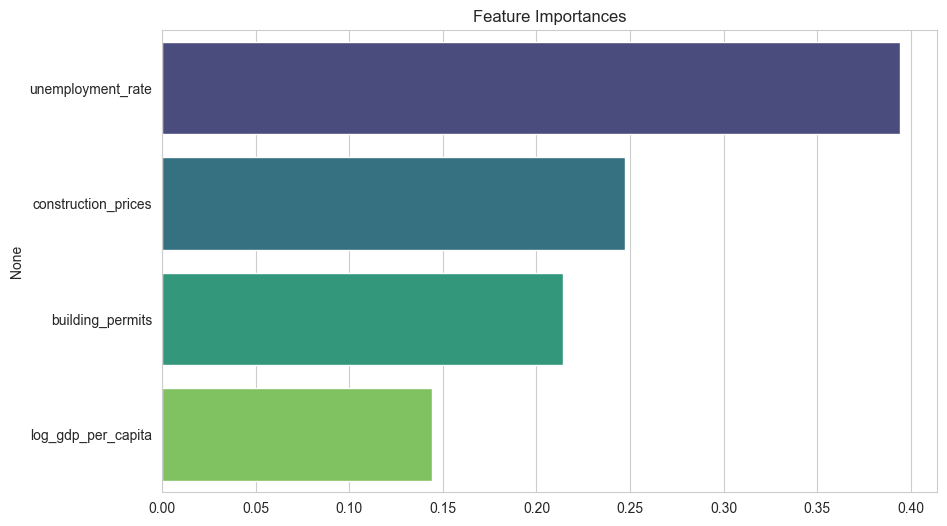

R² (metoda score): 0.5303913641678026
R² (r2_score): 0.5303913641678026


In [170]:
#xgboost
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"XGBoost MSE: {mse:.4f}")

importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=X.columns[indices], palette="viridis")
plt.title("Feature Importances")
plt.show()

# Calculăm R² folosind metoda score
r2_method = xgb_model.score(X_test, y_test)

# Calculăm R² folosind r2_score
r2_metric = r2_score(y_test, y_pred)

print("R² (metoda score):", r2_method)
print("R² (r2_score):", r2_metric)